# Import modules, set some constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import gaussian_kde

pi = np.pi

NSAMPLES = 100000

OUMUAMUA_COORDS = [np.radians(279.804-360), np.radians(33.997)]            # from Mamajek (2017)
VSUN = np.array([10.0, 5.2, 7.2])            # from Binney and Merrifield (1998)

S1 = 26                                      # from Binney and Merrifield (1998)
S2 = 18                                      # taken for G stars
S3 = 15
PHI = 2                                      # taken from Darryl's paper

THETA = np.radians(123)                      # this comes from Jo Bovy's stellar kinematics Github
ANGP = np.radians(192.25)
DNGP = np.radians(27.4)

# Draw galactic velocities from Schwarzschild distribution

In [2]:
def get_velocities(s1=S1, s2=S2, s3=S3):
    U = np.random.normal(scale=s1, size=NSAMPLES)            # draw from Schwarzschild distribution
    V = np.random.normal(scale=s2, size=NSAMPLES)
    W = np.random.normal(scale=s3, size=NSAMPLES)
    
    return np.column_stack((U, V, W))

vel = get_velocities()

# Convert to heliocentric

In [3]:
vel = vel - np.tile(VSUN, (NSAMPLES, 1))

In [4]:
T1 = [[np.cos(THETA), np.sin(THETA), 0], [np.sin(THETA), -np.cos(THETA), 0], [0, 0, 1]]    # this comes from Jo Bovy's
T2 = [[-np.sin(DNGP), 0, np.cos(DNGP)], [0, 1, 0], [np.cos(DNGP), 0, np.sin(DNGP)]]        # stellar kinematics github
T3 = [[np.cos(ANGP), np.sin(ANGP), 0], [-np.sin(ANGP), np.cos(ANGP), 0], [0, 0, 1]]

T = np.matmul(np.matmul(T1, T2), T3)                                                       # transform from galactic to 
                                                                                           # equatorial
for i, v in enumerate(vel):
    vel[i] = np.matmul(np.linalg.inv(T), v)

# Get right ascension + declination

In [5]:
def get_ra_dec(v):
    mag = np.sqrt(np.sum(v**2))
    dec = np.arcsin(v[2]/mag)
    if v[1]/mag > 0:
        ra = np.arccos(v[0]/(mag*np.cos(dec)))
    else:
        ra = 2*pi-np.arccos(v[0]/(mag*np.cos(dec)))
    if ra > pi:
        ra = ra - 2*pi
    return np.asarray([ra, dec])

pos = np.zeros((NSAMPLES, 2))
for i, v in enumerate(vel):
    pos[i] = get_ra_dec(-v)                             # draw vector pointing towards object rather than away from it

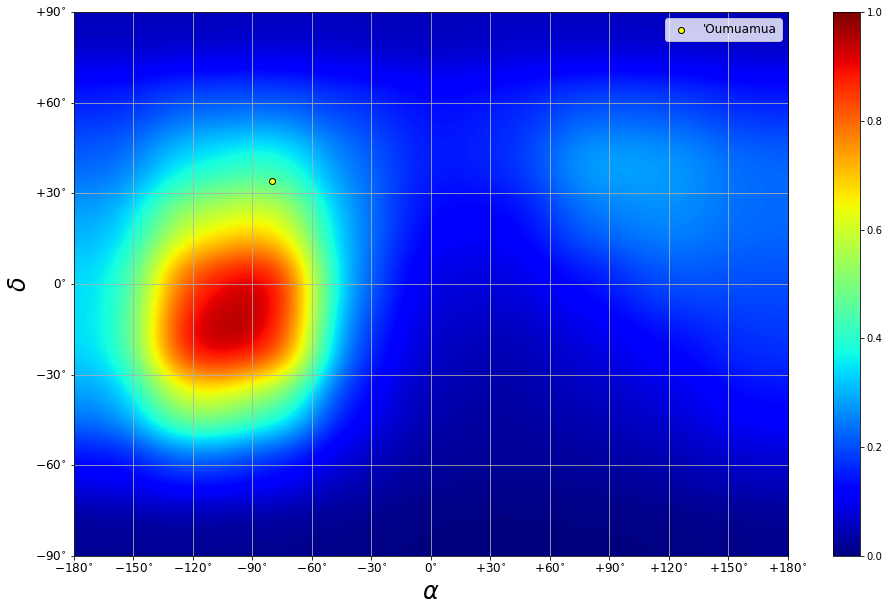

In [6]:
plt.figure(figsize=(16, 10))

xedges = np.linspace(-pi, pi, 10)
yedges = np.linspace(-pi/2, pi/2, 10)

H, xedges, yedges = np.histogram2d(pos[:, 0], pos[:, 1], bins=(xedges, yedges))
plt.imshow(H.transpose()[::-1], extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='gaussian', aspect='auto', \
           cmap='jet')

plt.xlabel(r'$\alpha$', fontsize=24)
plt.xticks([-pi, -5*pi/6, -2*pi/3, -pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6, pi], [r'$-180^{\circ}$', \
        r'$-150^{\circ}$', r'$-120^{\circ}$', r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', r'$0^{\circ}$', \
        r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$', r'$+120^{\circ}$', r'$+150^{\circ}$', r'$+180^{\circ}$'], \
          fontsize=12)

plt.ylabel(r'$\delta$', fontsize=24)
plt.yticks([-pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2], [r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', \
        r'$0^{\circ}$', r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$'], fontsize=12)
plt.grid(True)

plt.scatter(OUMUAMUA_COORDS[0], OUMUAMUA_COORDS[1], c='yellow', edgecolor='k', label="'Oumuamua")
plt.legend(loc='upper right', fontsize=12)
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='jet'))

plt.show()

In [7]:
def get_weights(vel):                                             # weighted from Equation 17 in Darryl's paper
    v_inf = np.sqrt(np.sum(vel**2, axis=1))
    return 1+(42/(v_inf+PHI))**2

w = get_weights(vel)

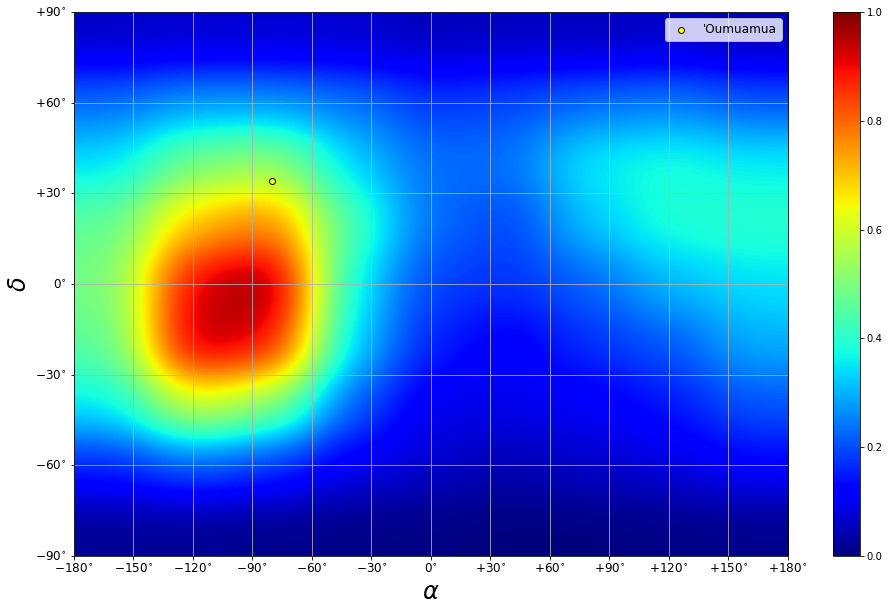

In [8]:
plt.figure(figsize=(16, 10))                                                   

xedges = np.linspace(-pi, pi, 10)
yedges = np.linspace(-pi/2, pi/2, 10)

H, xedges, yedges = np.histogram2d(pos[:, 0], pos[:, 1], bins=(xedges, yedges), weights=w)
plt.imshow(H.transpose()[::-1], extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='gaussian', aspect='auto', \
           cmap='jet')

plt.xlabel(r'$\alpha$', fontsize=24)
plt.xticks([-pi, -5*pi/6, -2*pi/3, -pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6, pi], [r'$-180^{\circ}$', \
        r'$-150^{\circ}$', r'$-120^{\circ}$', r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', r'$0^{\circ}$', \
        r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$', r'$+120^{\circ}$', r'$+150^{\circ}$', r'$+180^{\circ}$'], \
          fontsize=12)

plt.ylabel(r'$\delta$', fontsize=24)
plt.yticks([-pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2], [r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', \
        r'$0^{\circ}$', r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$'], fontsize=12)
plt.grid(True)

plt.scatter(OUMUAMUA_COORDS[0], OUMUAMUA_COORDS[1], c='yellow', edgecolor='k', label="'Oumuamua")
plt.legend(loc='upper right', fontsize=12)
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='jet'))

plt.show()